In [1]:
from ucimlrepo import fetch_ucirepo

In [2]:
# fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

# metadata
print(breast_cancer_wisconsin_original.metadata)

# variable information
print(breast_cancer_wisconsin_original.variables)

{'uci_id': 15, 'name': 'Breast Cancer Wisconsin (Original)', 'repository_url': 'https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original', 'data_url': 'https://archive.ics.uci.edu/static/public/15/data.csv', 'abstract': 'Original Wisconsin Breast Cancer Database', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 699, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Class'], 'index_col': ['Sample_code_number'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1990, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5HP4Z', 'creators': ['WIlliam Wolberg'], 'intro_paper': None, 'additional_info': {'summary': "Samples arrive periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, having been removed fro

In [3]:
# Remove rows with missing values
nan_indexes = X[X.isna().any(axis=1)].index
X = X.drop(nan_indexes)
y = y.drop(nan_indexes)
X.shape

(683, 9)

In [4]:
import jax.numpy as np

# Convert DataFrames to numpy (JAX) arrays
X_arr = np.asarray(X.to_numpy(), dtype=float)
y_arr = np.asarray(y.to_numpy() / 2 - 1.0)

I0000 00:00:1700415143.703197       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [16]:
from NeuralNetwork import NeuralNet
from CostFuncs import (
    CostCrossEntropy_fast,
    CostCrossEntropy_binary,
)
from Activators import sigmoid, ReLU, softmax, LRELU, zero_one_clip
from jax import jit
from CostFuncs import CostCrossEntropy_fast, CostCrossEntropy_binary

dimensions = (9, 50, 50, 75, 1)
FFNN = NeuralNet(
    dimensions,
    hidden_func=zero_one_clip,
    output_func=sigmoid,
    seed=2023,
    cost_func=CostCrossEntropy_binary,
)

In [17]:
from Schedules import Adam

from jax.config import config

config.update("jax_debug_nans", True)

scores = FFNN.fit(
    X_arr,
    y_arr,
    epochs=200,
    batches=40,
    scheduler=Adam(0.0001, 0.9, 0.999),
    lmbda=0.0001,
)

  0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 8000/8000 [00:26<00:00, 300.33it/s]


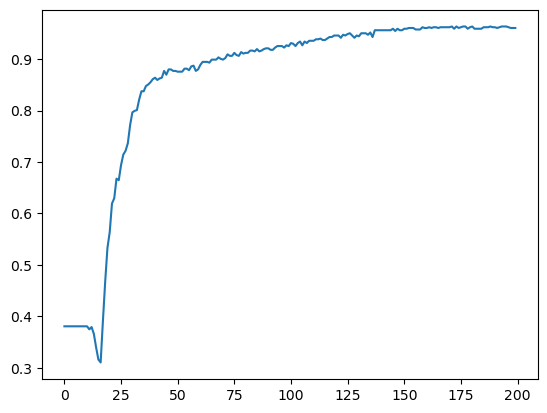

In [12]:
import matplotlib.pyplot as plt

plt.plot(scores["train_accuracy"])

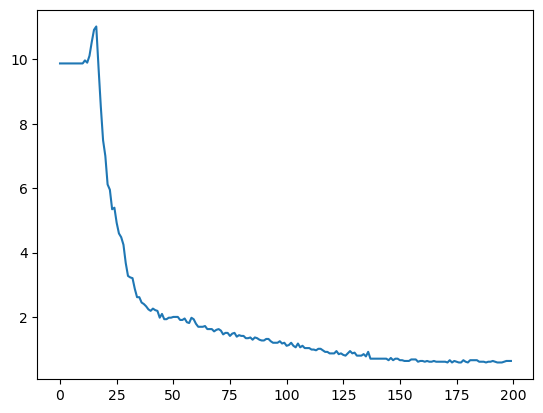

In [13]:
plt.plot(scores["train_errors"])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_arr, y_arr, test_size=0.2, random_state=2023
)

In [15]:
from NeuralNetwork import NeuralNet
from Activators import sigmoid
from CostFuncs import CostCrossEntropy_binary
from Schedules import Adam, Constant

dimensions = (9, 50, 50, 1)
FFNN = NeuralNet(
    dimensions,
    hidden_func=sigmoid,
    output_func=sigmoid,
    cost_func=CostCrossEntropy_binary,
    seed=2023,
)

scores = FFNN.fit(
    X_train,
    y_train,
    # scheduler=Adam(0.001, 0.9, 0.999),
    scheduler=Adam(0.01, 0.9, 0.999),
    batches=20,
    epochs=400,
    lmbda=0.000001,
    X_val=X_test,
    target_val=y_test,
)

100%|██████████| 8000/8000 [00:19<00:00, 415.37it/s]


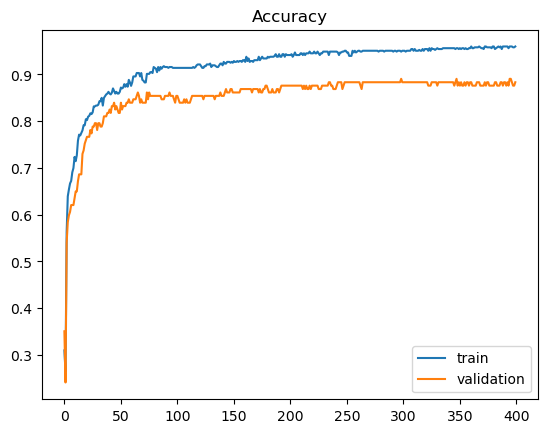

In [37]:
import matplotlib.pyplot as plt

plt.plot(scores["train_accuracy"], label="train")
plt.plot(scores["validation_accuracy"], label="validation")
plt.legend()
plt.title("Accuracy")
plt.show()

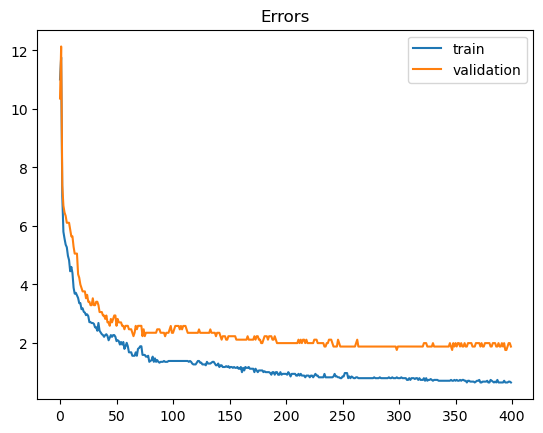

In [38]:
import matplotlib.pyplot as plt

plt.plot(scores["train_errors"], label="train")
plt.plot(scores["validation_errors"], label="validation")
plt.legend()
plt.title("Errors")
plt.show()

In [21]:
from Schedules import Scheduler
from typing import Callable
from Activators import sigmoid
from NeuralNetwork import NeuralNet
from CostFuncs import CostCrossEntropy_binary


def explore(
    schedule: Scheduler,
    total_scores: dict,
    func: Callable = sigmoid,
):
    name = schedule.__class__.__name__
    curr_scores = [[None for j in range(5)] for i in range(5)]
    dimensions = (9, 75, 75, 100, 1)
    lmbda_arr = np.logspace(-5, -1, 5)
    eta_arr = np.logspace(-5, -1, 5)
    for i, lmbda in enumerate(lmbda_arr):
        for j, eta in enumerate(eta_arr):
            FFNN = NeuralNet(
                dimensions,
                hidden_func=func,
                output_func=sigmoid,
                cost_func=CostCrossEntropy_binary,
                seed=2023,
            )
            schedule.eta = eta
            scores = FFNN.fit(
                X_train,
                y_train,
                scheduler=schedule,
                batches=20,
                epochs=100,
                lmbda=lmbda,
                X_val=X_test,
                target_val=y_test,
            )
            curr_scores[i][j] = scores
    total_scores[name] = curr_scores

In [22]:
from Schedules import Constant, Momentum, Adam, RMS_prop, Adagrad, AdagradMomentum

schedulers = [
    Constant(0),
    Momentum(0, 0.9),
    Adam(0, 0.9, 0.999),
    RMS_prop(0, 0.9),
    Adagrad(0),
    AdagradMomentum(0, 0.9),
]
schedule_names = [schedule.__class__.__name__ for schedule in schedulers]

In [23]:
from Activators import sigmoid

simgoid_dict = dict()
for scheduler in schedulers:
    explore(scheduler, simgoid_dict, sigmoid)

100%|██████████| 2000/2000 [00:03<00:00, 525.45it/s]


In [25]:
from Activators import ReLU

ReLU_dict = dict()
for scheduler in schedulers:
    explore(scheduler, ReLU_dict, ReLU)

100%|██████████| 2000/2000 [00:03<00:00, 645.76it/s]


In [26]:
from Activators import LRELU

LRELU_dict = dict()
for scheduler in schedulers:
    explore(scheduler, LRELU_dict, LRELU)

100%|██████████| 2000/2000 [00:03<00:00, 592.00it/s]


In [27]:
from Activators import zero_one_clip

zero_one_clip_dict = dict()
for scheduler in schedulers:
    explore(scheduler, zero_one_clip_dict, zero_one_clip)

100%|██████████| 2000/2000 [00:03<00:00, 632.17it/s]


In [33]:
import pandas as pd
from plotutils import plotHeatmap
from pathlib import Path
import numpy as onp

basePath = Path.cwd().parent.parent / "figures/cancer_classification"
basePath.mkdir(parents=True, exist_ok=True)


def plot_heatmap_cancer(
    curr_scores: list[list[np.ndarray]], scheduleName: str, funcName: str
):
    lmbda_arr = np.logspace(-5, -1, 5)
    eta_arr = np.logspace(-5, -1, 5)
    data = onp.zeros((5, 5))
    for i, lmbda in enumerate(lmbda_arr):
        for j, eta in enumerate(eta_arr):
            data[i][j] = curr_scores[i][j]["validation_accuracy"][-1]
    df = pd.DataFrame(
        data=data,
        index=lmbda_arr,
        columns=eta_arr,
    )
    plotHeatmap(
        df,
        f"{funcName} {scheduleName} Accuracy",
        x_label=r"$\eta$",
        y_label=r"$\lambda$",
        savePlots=True,
        figsPath=basePath,
        saveName=f"{funcName}_{scheduleName}_accuracy",
    )

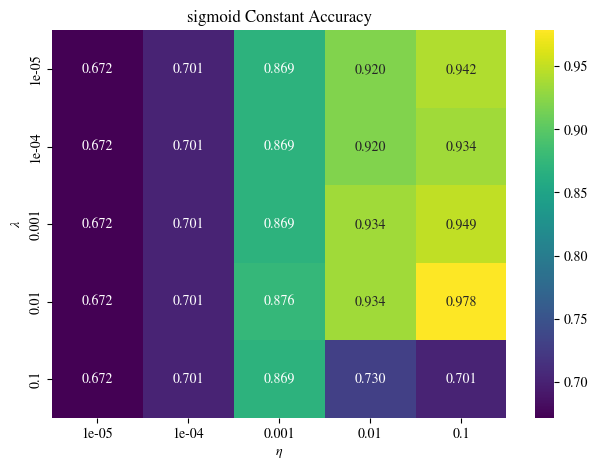

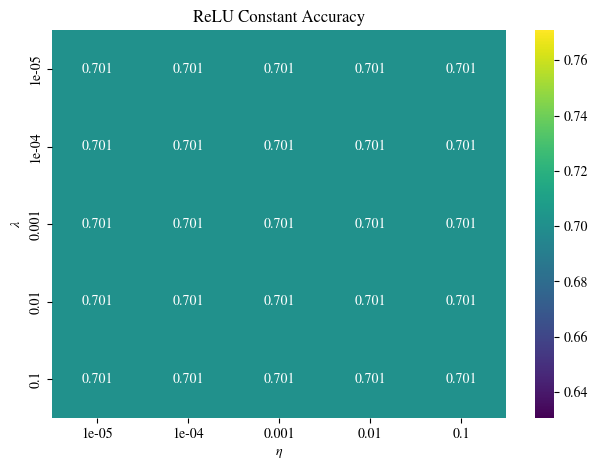

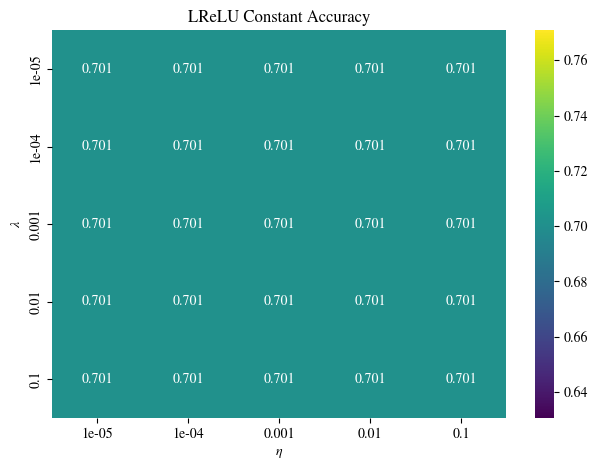

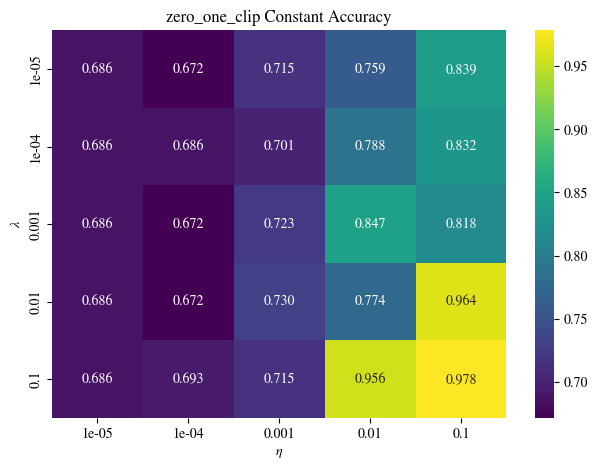

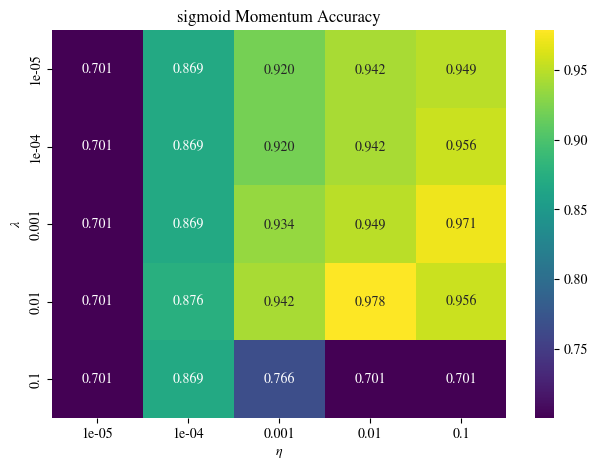

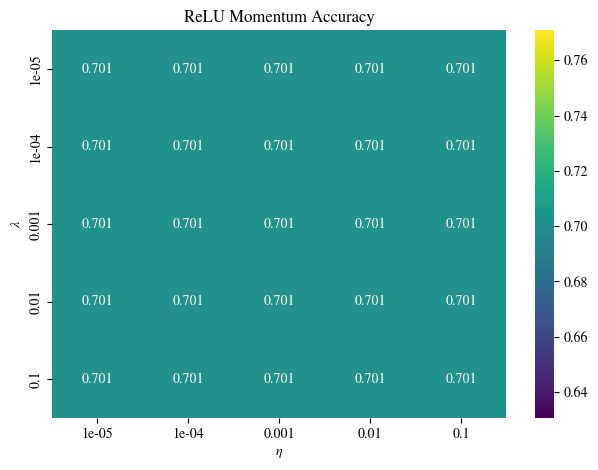

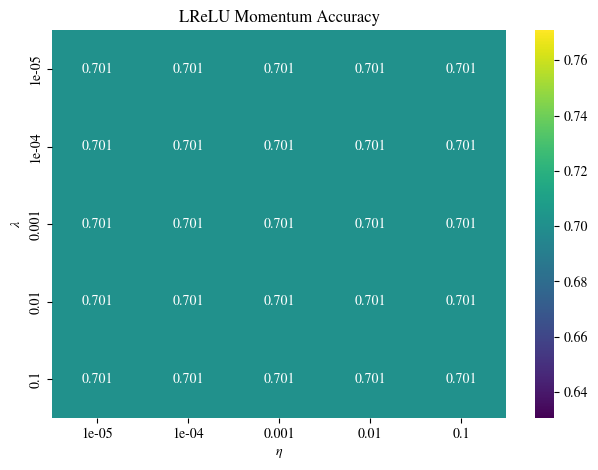

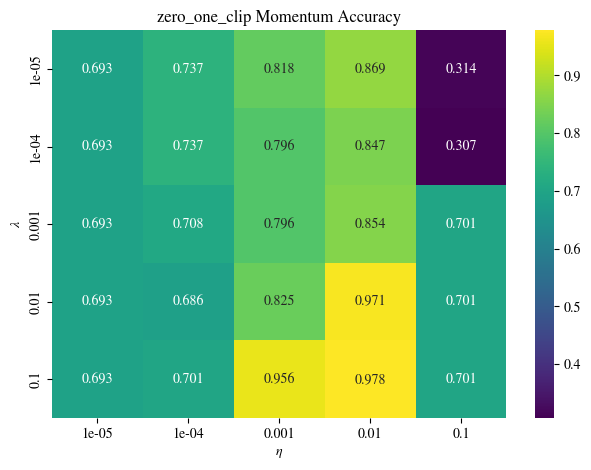

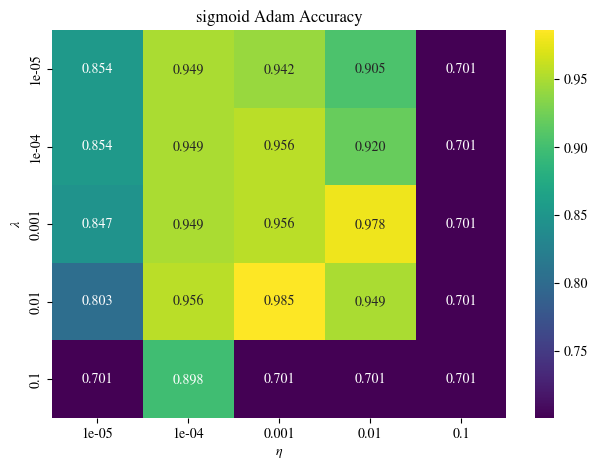

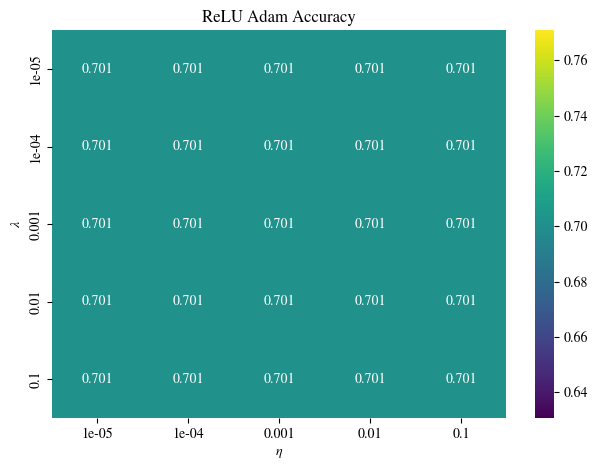

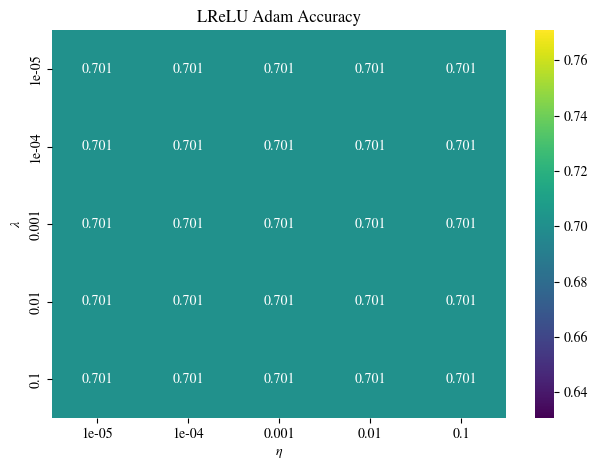

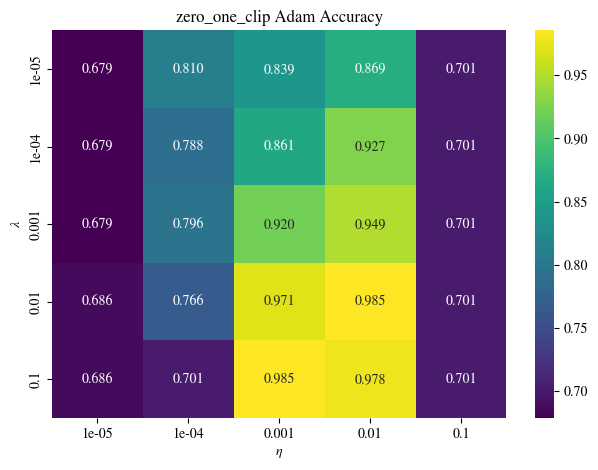

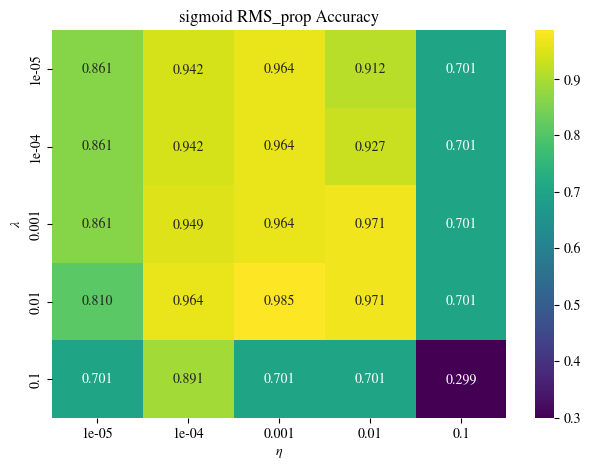

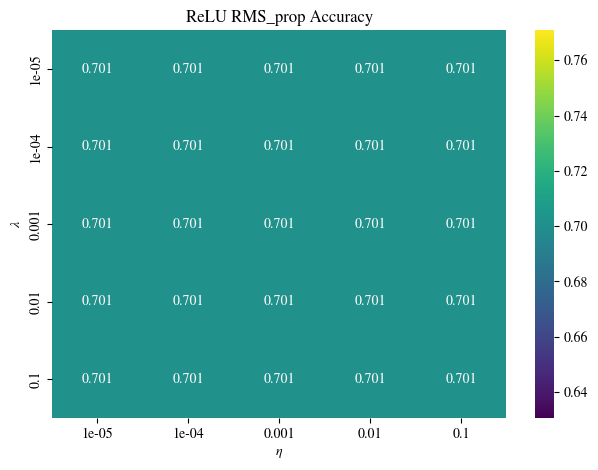

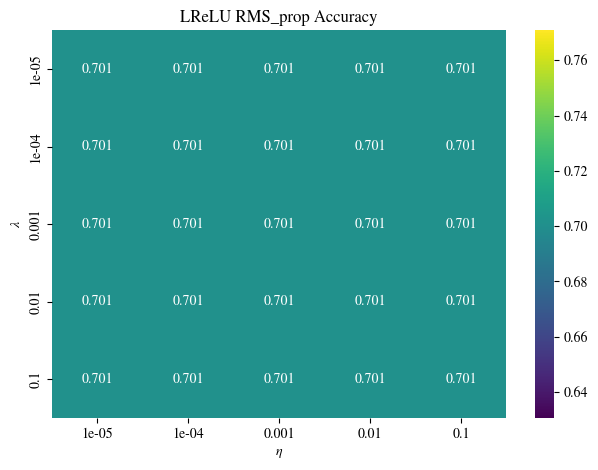

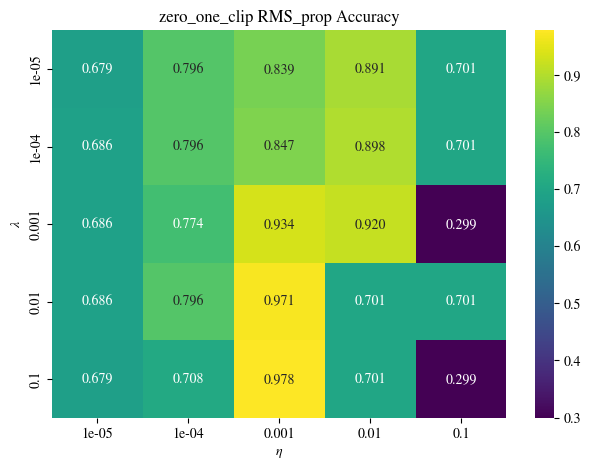

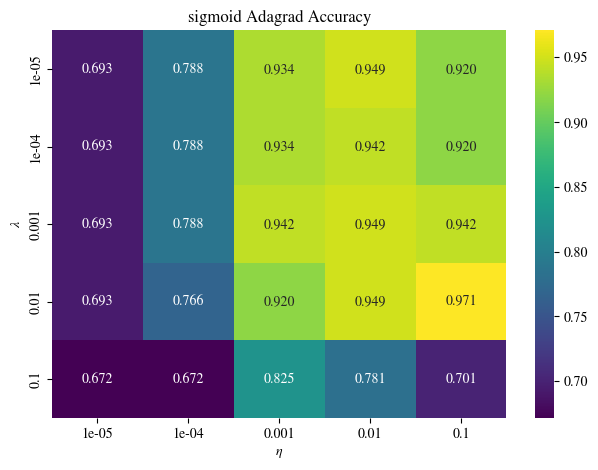

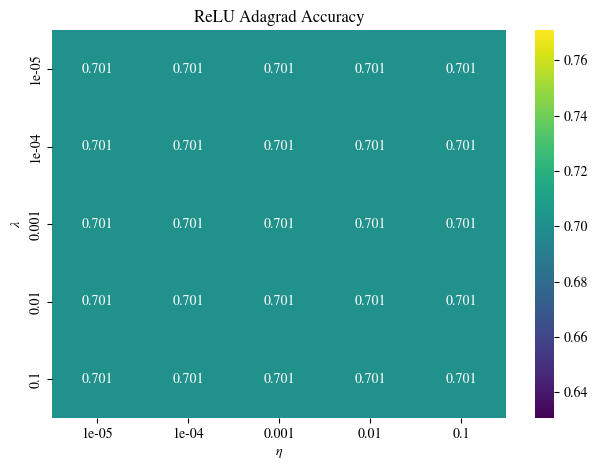

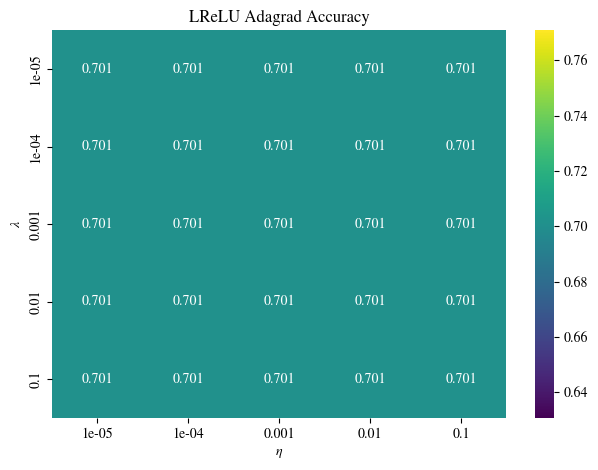

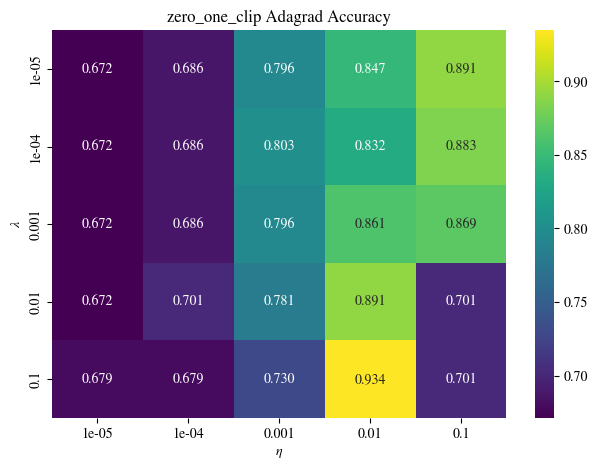

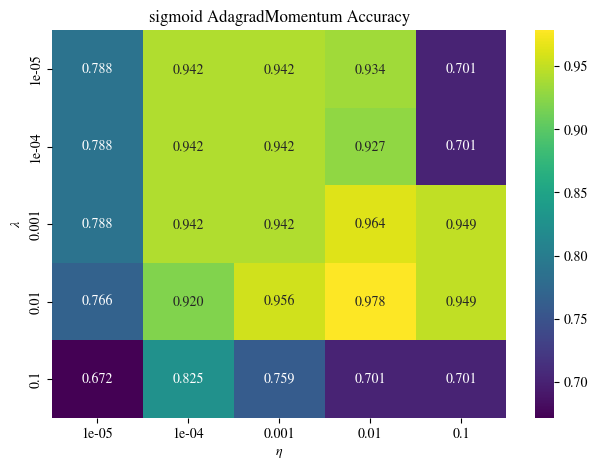

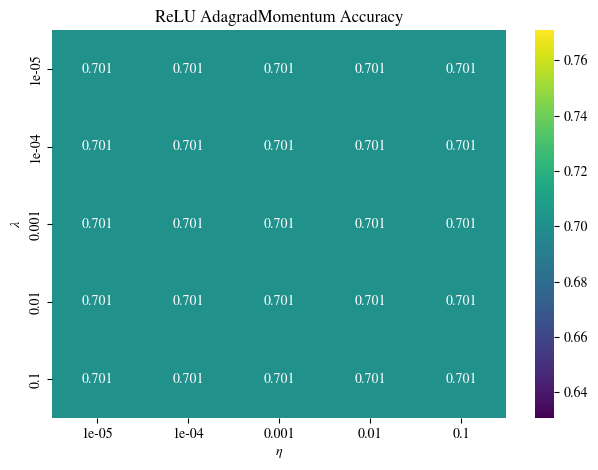

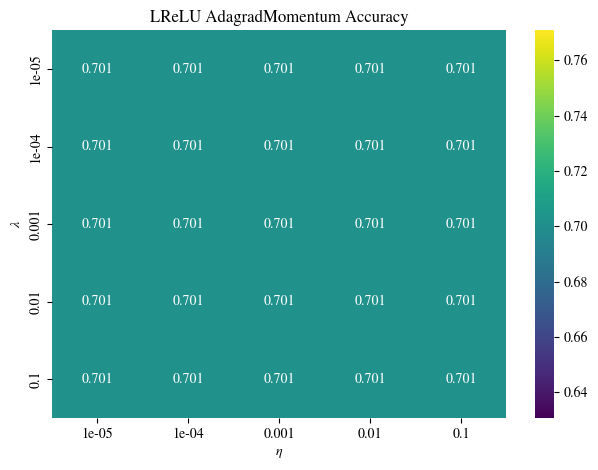

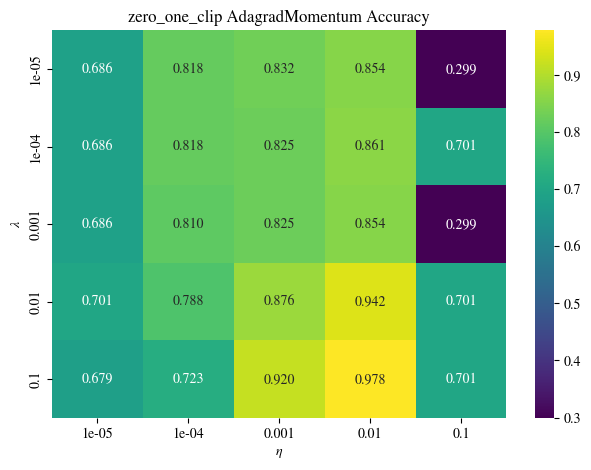

In [34]:
for scheduleName in schedule_names:
    plot_heatmap_cancer(simgoid_dict[scheduleName], scheduleName, "sigmoid")
    plot_heatmap_cancer(ReLU_dict[scheduleName], scheduleName, "ReLU")
    plot_heatmap_cancer(LRELU_dict[scheduleName], scheduleName, "LReLU")
    plot_heatmap_cancer(
        zero_one_clip_dict[scheduleName], scheduleName, "zero_one_clip")